In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

In [22]:
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models

import numpy as np
import random

# from src.models.resnet import ResNet50
from src.norm.norm_layer import replace_norm_layer
from src.data.loaders import get_cifar_loader
from src.models.vgg import VGG16

from torchsummary import summary
from tqdm import tqdm

from IPython import display

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def set_random_seeds(seed_value=0, device='cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [8]:
def get_accuracy(model, dataloader, device='gpu'):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  ## <---
            y = y.to(device)  ## <---
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

In [9]:
def get_loss(model, dataloader, criterion, device='gpu'):
    loss_ = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)
            loss = criterion(prediction, y)
            loss_ += loss.item()
    return loss / len(dataloader)

In [10]:
def train(model, 
          optimizer, 
          criterion,  
          train_loader, 
          val_loader, 
          scheduler=None, 
          epochs_n=100, 
          best_model_path=None):
    
    model.to(device)
    learning_curve = [np.nan] * epochs_n
    val_learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        if scheduler is not None:  
            scheduler.step()       
        model.train()

        learning_curve[epoch] = 0
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()
        
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)
        
        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        val_learning_curve[epoch] = get_loss(model, val_loader, criterion, device)
        axes[0].plot(val_learning_curve)
        axes[0].set_title('LT {:.4f}, LV {:.4f}'.format(
            learning_curve[epoch], val_learning_curve[epoch]))

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if best_model_path:
                torch.save(model.state_dict(), best_model_path)
        
        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
        
    return learning_curve, val_learning_curve, train_accuracy_curve, val_accuracy_curve

In [11]:
batch_size = 128
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


# ResNet50

In [12]:
training_results = {}

## GN

In [13]:
resnet50 = models.resnet50(pretrained=False).to(device)
resnet50_gn = replace_norm_layer(resnet50, new_norm_layer='gn')
resnet50_gn = resnet50_gn.to(device)

In [14]:
print(resnet50_gn.bn1)

GroupNorm(32, 64, eps=1e-05, affine=True)


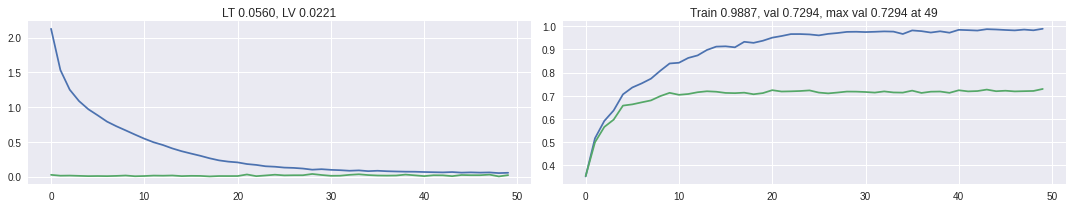

100%|██████████| 50/50 [42:55<00:00, 51.52s/epoch]


In [15]:
lr = 1e-3
model_name = 'resnet50_gn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = resnet50_gn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## BN

In [16]:
resnet50_bn = models.resnet50(pretrained=False).to(device)

In [17]:
print(resnet50_bn.bn1)

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


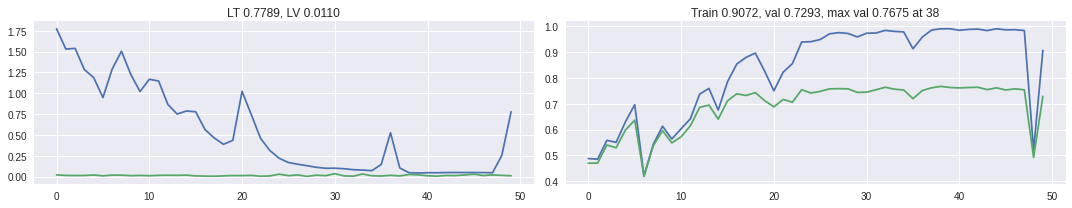

100%|██████████| 50/50 [32:49<00:00, 39.40s/epoch]


In [18]:
lr = 1e-3
model_name = 'resnet50_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = resnet50_bn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## No Norm Layer

In [81]:
resnet50 = models.resnet50(pretrained=False).to(device)
resnet50 = replace_norm_layer(resnet50, new_norm_layer=None)
resnet50 = resnet50.to(device)

In [82]:
print(resnet50.bn1)

Identity()


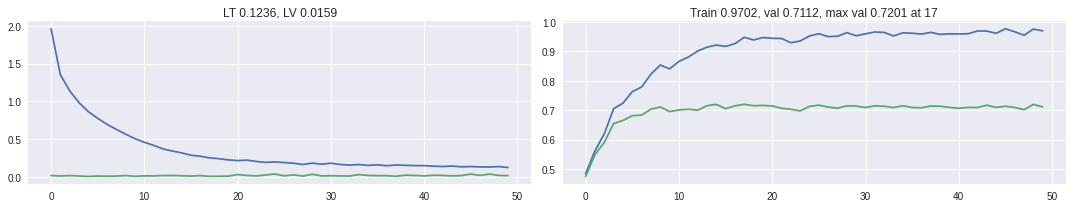

100%|██████████| 50/50 [24:28<00:00, 29.38s/epoch]


In [83]:
lr = 1e-3
model_name = 'resnet50'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = resnet50

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

<ipython-input-84-3aa04f105000>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(figures_path, 'comparison_gn.png'), dpi=500, quality=100)


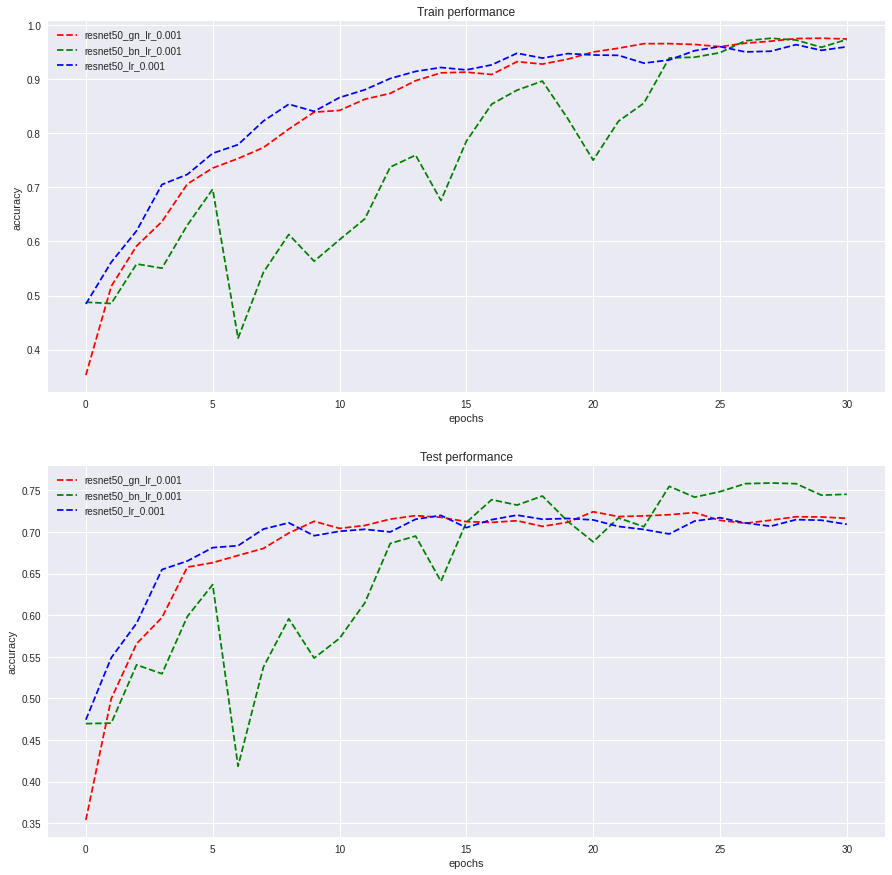

In [84]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for exp_name, result in training_results.items():
    learning_curve, _, train_accuracy_curve, val_accuracy_curve = result
    
    if '0.001' in exp_name:
        if 'bn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'g--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g--', label=exp_name)
        elif 'gn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'r--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r--', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'b--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'b--', label=exp_name)

axs[0].set_title('Train performance')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].set_title('Test performance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.savefig(os.path.join(figures_path, 'comparison_gn_resnet.png'), dpi=500, quality=100)
plt.show()

In [112]:
import pickle
def save_obj(obj, name ):
    with open('../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [118]:
save_obj(training_results, 'resnet50_result')

In [119]:
test = load_obj('resnet50_result')

# DenseNet121

In [85]:
training_results_densenet = {}

## GN

In [86]:
densenet121 = models.densenet121(pretrained=False).to(device)
densenet121_gn = replace_norm_layer(densenet121, new_norm_layer='gn')
densenet121_gn = densenet121_gn.to(device)

In [87]:
print(densenet121_gn.features.norm0)

GroupNorm(32, 64, eps=1e-05, affine=True)


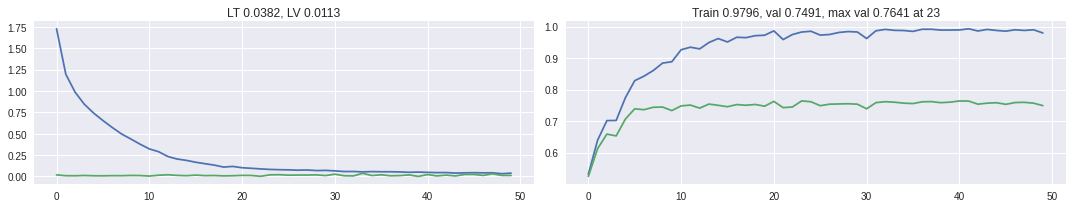

100%|██████████| 50/50 [32:48<00:00, 39.36s/epoch]


In [88]:
lr = 1e-3
model_name = 'densenet121_gn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = densenet121_gn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_densenet[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## BN

In [89]:
densenet121_bn = models.densenet121(pretrained=False).to(device)

In [90]:
print(densenet121_bn.features.norm0)

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


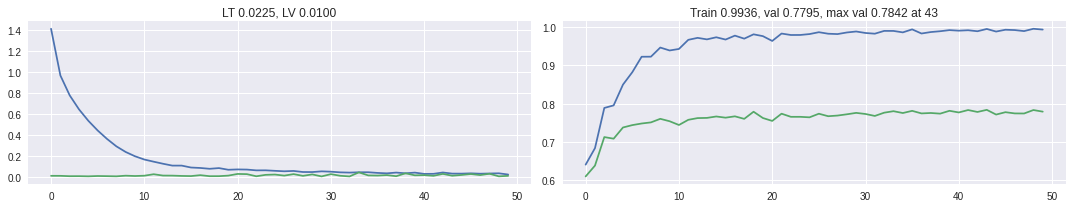

100%|██████████| 50/50 [33:32<00:00, 40.25s/epoch]


In [91]:
lr = 1e-3
model_name = 'densenet121_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = densenet121_bn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_densenet[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## No Norm Layer

In [92]:
densenet121 = models.densenet121(pretrained=False).to(device)
densenet121 = replace_norm_layer(densenet121, new_norm_layer=None)
densenet121 = densenet121.to(device)

In [93]:
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): Identity()
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      

In [94]:
print(densenet121.features.norm0)

Identity()


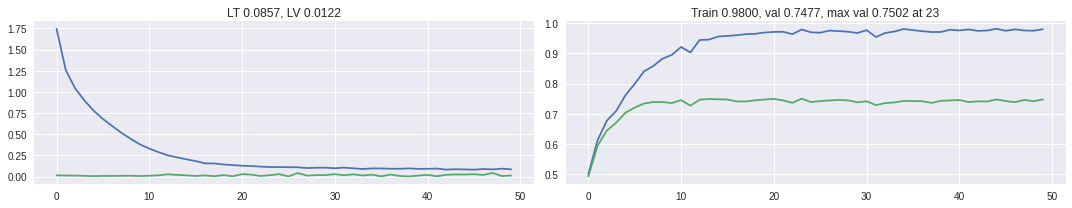

100%|██████████| 50/50 [22:10<00:00, 26.60s/epoch]


In [95]:
lr = 1e-3
model_name = 'densenet121'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = densenet121

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_densenet[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

<ipython-input-96-b157f1d29e5a>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(figures_path, 'comparison_gn.png'), dpi=500, quality=100)


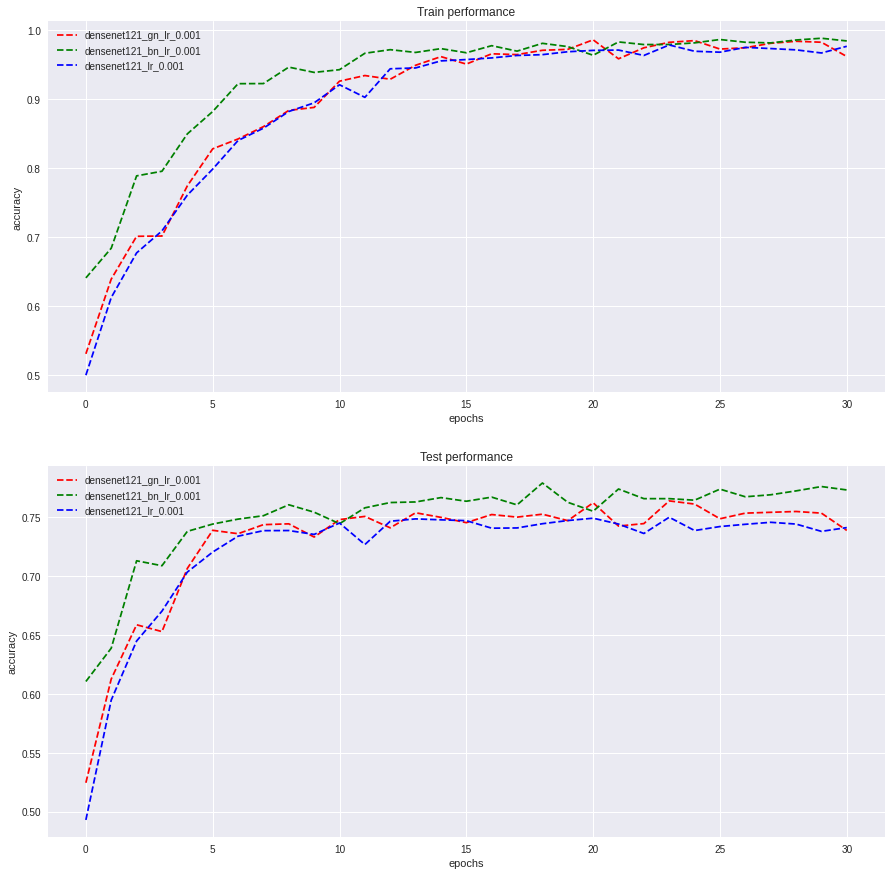

In [96]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for exp_name, result in training_results_densenet.items():
    learning_curve, _, train_accuracy_curve, val_accuracy_curve = result
    
    if '0.001' in exp_name:
        if 'bn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'g--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g--', label=exp_name)
        elif 'gn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'r--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r--', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'b--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'b--', label=exp_name)

axs[0].set_title('Train performance')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].set_title('Test performance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.savefig(os.path.join(figures_path, 'comparison_gn_densenet.png'), dpi=500, quality=100)
plt.show()

In [121]:
save_obj(training_results_densenet, 'densenet121_result')

In [122]:
test = load_obj('densenet121_result')

# VGG16

In [97]:
training_results_vgg16 = {}

## GN

In [98]:
vgg16_gn = VGG16(norm='gn').to(device)

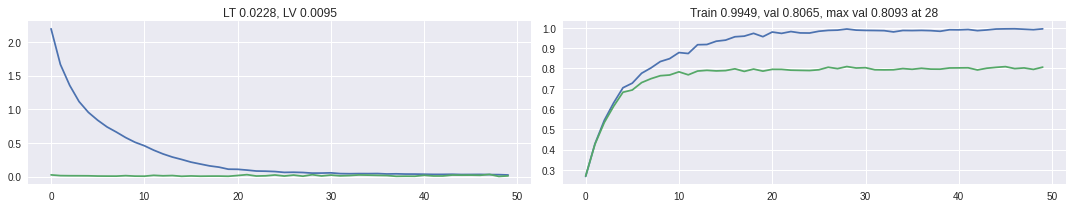

100%|██████████| 50/50 [17:45<00:00, 21.32s/epoch]


In [105]:
lr = 1e-3
model_name = 'vgg16_gn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16_gn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## BN

In [100]:
vgg16_bn = VGG16(norm='bn').to(device)

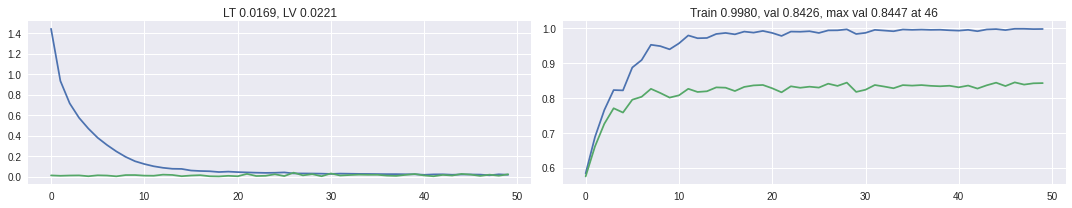

100%|██████████| 50/50 [14:17<00:00, 17.16s/epoch]


In [101]:
lr = 1e-3
model_name = 'vgg16_bn'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16_bn

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

## No Normalization

In [102]:
vgg16 = VGG16(norm=None).to(device)

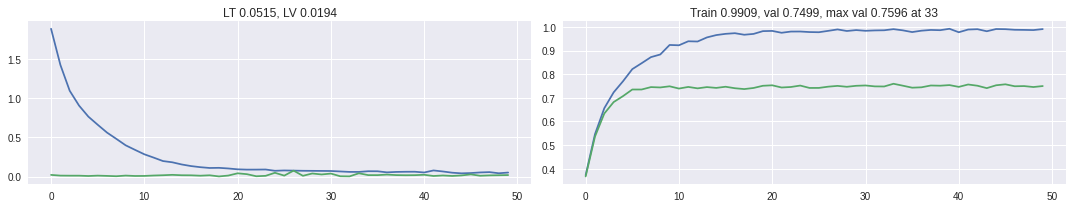

100%|██████████| 50/50 [13:02<00:00, 15.66s/epoch]


In [103]:
lr = 1e-3
model_name = 'vgg16'
experimment_name = f'{model_name}_lr_{lr}'
model_path = os.path.join(models_path, f'{experimment_name}.pt') #change dump name here

set_random_seeds(seed_value=2021, device=device)
model = vgg16

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results_vgg16[experimment_name] = train(model, 
                                           optimizer, 
                                           criterion, 
                                           train_loader,
                                           val_loader,
                                           epochs_n=50, 
                                           best_model_path=model_path)

<ipython-input-106-2b4b55b10140>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(os.path.join(figures_path, 'comparison_gn_vgg16.png'), dpi=500, quality=100)


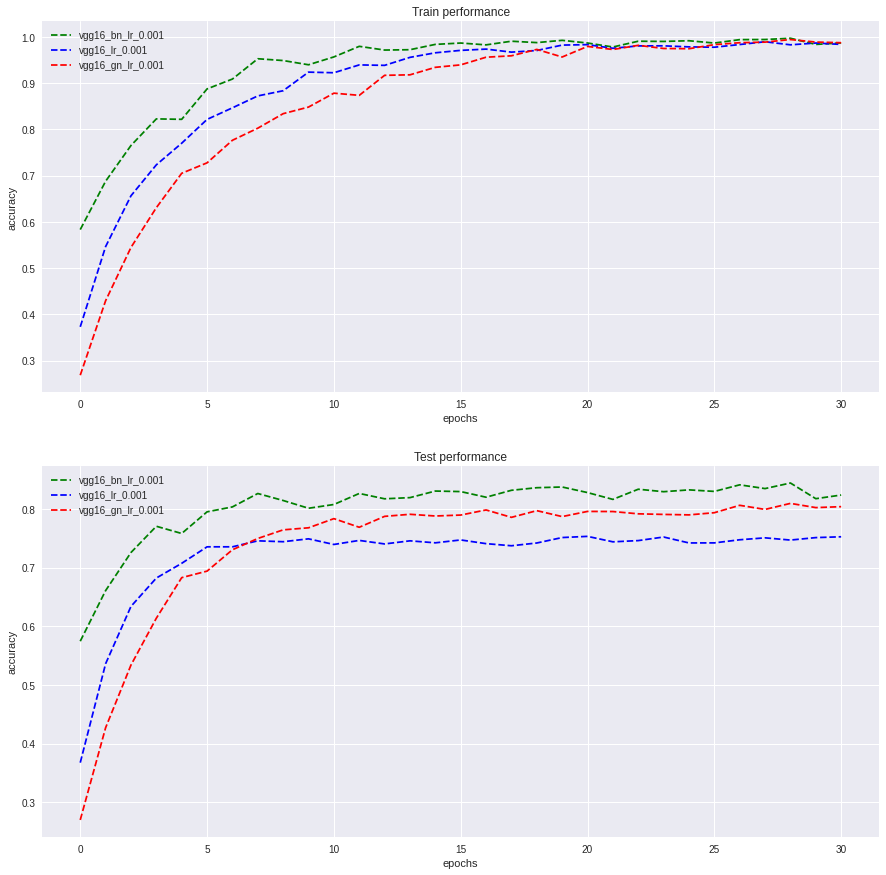

In [106]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for exp_name, result in training_results_vgg16.items():
    learning_curve, _, train_accuracy_curve, val_accuracy_curve = result
    
    if '0.001' in exp_name:
        if 'bn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'g--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'g--', label=exp_name)
        elif 'gn' in exp_name:
            axs[0].plot(train_accuracy_curve[:31], 'r--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'r--', label=exp_name)
        else:
            axs[0].plot(train_accuracy_curve[:31], 'b--', label=exp_name)
            axs[1].plot(val_accuracy_curve[:31], 'b--', label=exp_name)

axs[0].set_title('Train performance')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].set_title('Test performance')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.savefig(os.path.join(figures_path, 'comparison_gn_vgg16.png'), dpi=500, quality=100)
plt.show()

In [124]:
save_obj(training_results_vgg16, 'vgg16_result')

In [125]:
test = load_obj('vgg16_result')